In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc

In [2]:
# View first five rows
df = pd.read_csv('bank-additional-full.csv')
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Convert target labels to numeric
df['y'] = df['y'].map({'yes': 1, 'no': 0}).astype(int)

# Handling missing or unknown values
df.replace("unknown", np.nan, inplace=True)
df.dropna(inplace=True)  # Drop rows with missing values (alternative: impute values)

# One-hot encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Train-test split
X = df.drop(columns=['y'])
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

In [4]:
# Standardise features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# Model Evaluation Function

def evaluate_model(model, X_test, y_test, label):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"\nPerformance for {label}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {label}")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc(fpr, tpr):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {label}")
    plt.legend()
    plt.show()

In [6]:
# Train baseline model
baseline_model = AdaBoostClassifier(n_estimators = 50, random_state=42)
baseline_model.fit(X_train, y_train)

c:\Users\class\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(random_state=42)


Performance for Baseline Model:
Accuracy: 0.8993
Precision: 0.6756
Recall: 0.3938
F1 Score: 0.4975
ROC AUC: 0.9358

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      5324
           1       0.68      0.39      0.50       772

    accuracy                           0.90      6096
   macro avg       0.80      0.68      0.72      6096
weighted avg       0.89      0.90      0.89      6096



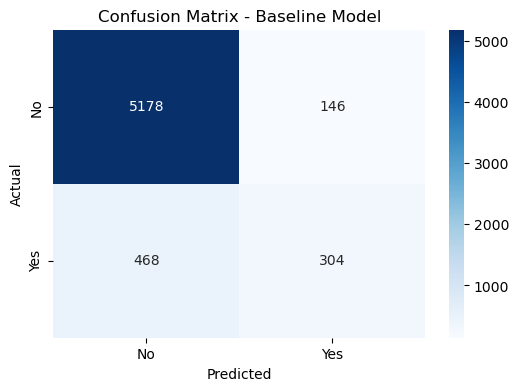

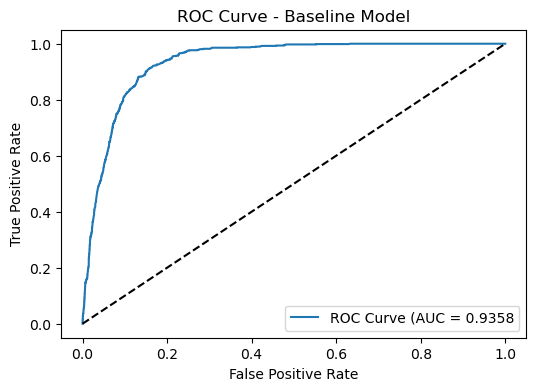

In [7]:
# Evaluate baseline model
evaluate_model(baseline_model, X_test, y_test, "Baseline Model")

In [8]:
# Hyperparameter Tuning with RandomizedSearchCV for efficiency
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0],
}

random_search = RandomizedSearchCV(AdaBoostClassifier(random_state=42), param_distributions=param_dist, cv=5, scoring='f1', n_jobs=-1, n_iter=10, random_state=42)
random_search.fit(X_train, y_train)
print(f"Best Parameters: {random_search.best_params_}")

c:\Users\class\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best Parameters: {'n_estimators': 400, 'learning_rate': 1.0}


In [9]:
# Fit final model with best parameters
final_model = random_search.best_estimator_
final_model.fit(X_train, y_train)

c:\Users\class\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=400, random_state=42)


Performance for Final Model (After Tuning):
Accuracy: 0.8980
Precision: 0.6562
Recall: 0.4080
F1 Score: 0.5032
ROC AUC: 0.9378

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      5324
           1       0.66      0.41      0.50       772

    accuracy                           0.90      6096
   macro avg       0.79      0.69      0.72      6096
weighted avg       0.89      0.90      0.89      6096



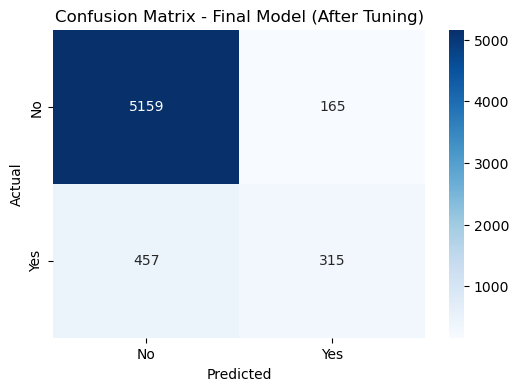

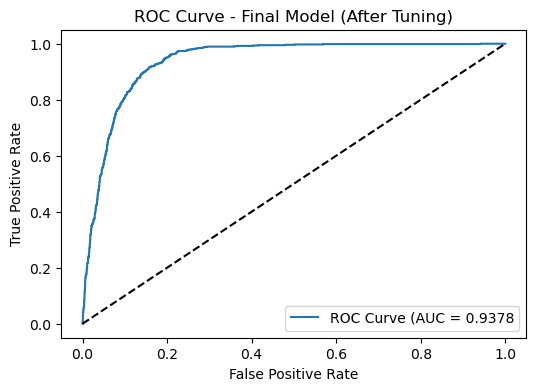

In [10]:
# Evaluate final models
evaluate_model(final_model, X_test, y_test, "Final Model (After Tuning)")

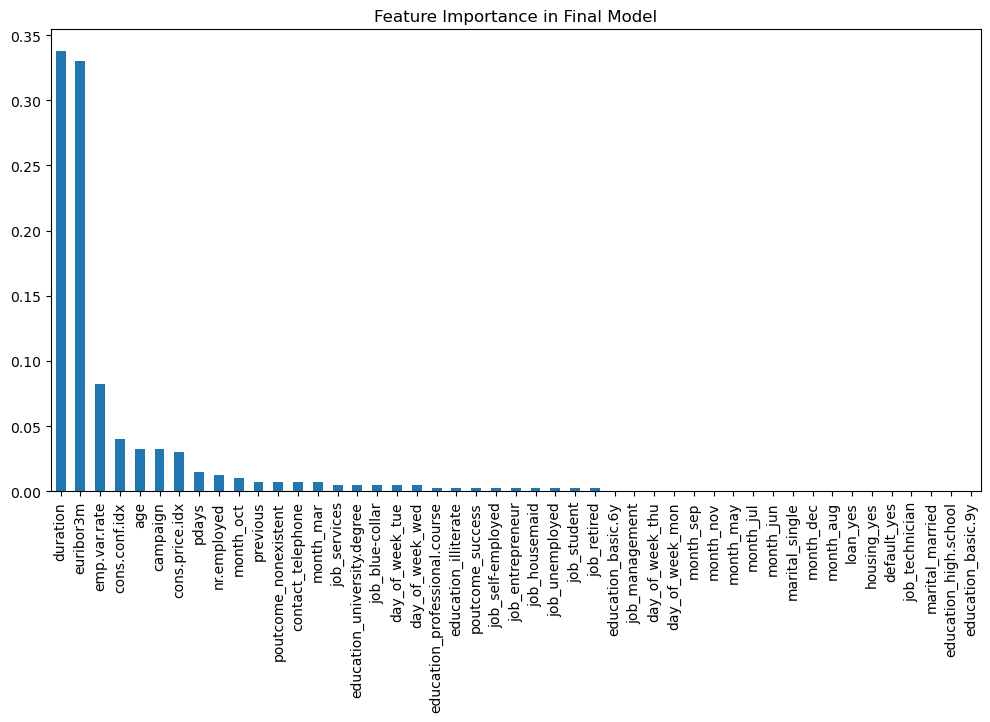

In [11]:
# Feature Importance Analysis
feature_importances = pd.Series(final_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind="bar", figsize=(12,6), title="Feature Importance in Final Model")
plt.show()


Performance for Final Model (Train Set):
Accuracy: 0.9059
Precision: 0.6974
Recall: 0.4533
F1 Score: 0.5495
ROC AUC: 0.9444

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95     21296
           1       0.70      0.45      0.55      3086

    accuracy                           0.91     24382
   macro avg       0.81      0.71      0.75     24382
weighted avg       0.90      0.91      0.90     24382



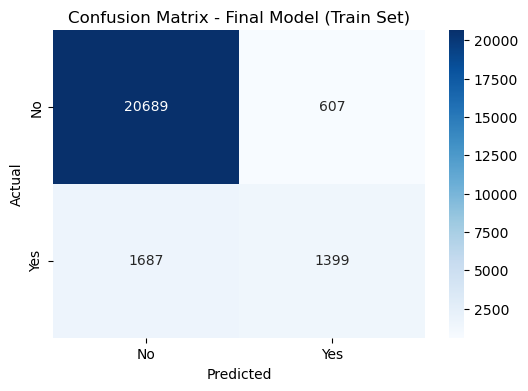

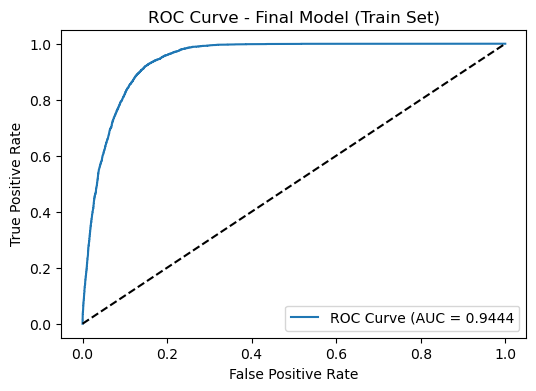


Performance for Final Model (Test Set):
Accuracy: 0.8980
Precision: 0.6562
Recall: 0.4080
F1 Score: 0.5032
ROC AUC: 0.9378

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      5324
           1       0.66      0.41      0.50       772

    accuracy                           0.90      6096
   macro avg       0.79      0.69      0.72      6096
weighted avg       0.89      0.90      0.89      6096



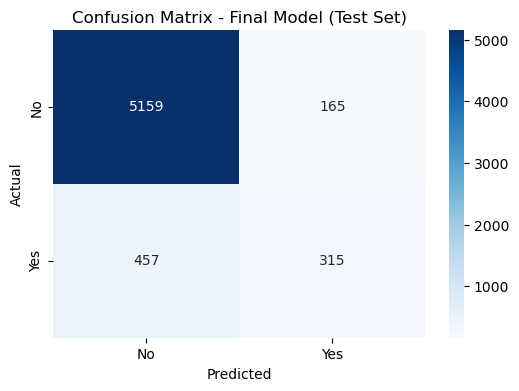

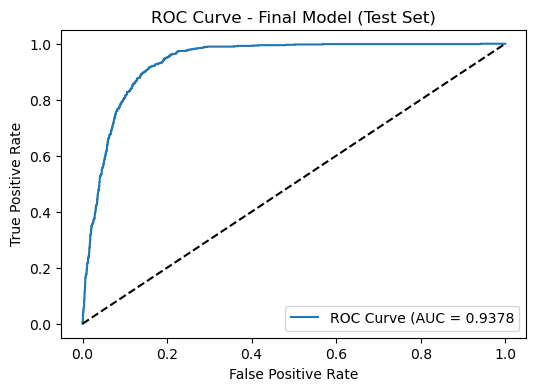

In [12]:
# Train vs Test Performance Comparison
evaluate_model(final_model, X_train, y_train, "Final Model (Train Set)")
evaluate_model(final_model, X_test, y_test, "Final Model (Test Set)")

In [13]:
df.shape

(30478, 48)